# Imports

In [78]:
import pandas as pd
import numpy as np

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('Solarize_Light2')

from itertools import combinations
import statsmodels.api as sm
from statsmodels.api import add_constant

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, scale, PolynomialFeatures, normalize
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [79]:
df = pd.read_csv('Desktop/ECO4443/dumps/sales.csv')
df.head()

,price,year,home_size,parcel_size,beds,age,pool,cbd_dist,x_coord,y_coord
0,113.327,2004,1175,10662,3,5,0,11582.05,572058.1,1538810
1,165.509,2000,1774,5851,3,6,1,20140.86,524003.1,1465890
2,225.060,2002,1560,7750,3,32,0,1670.04,536791.3,1525977
3,105.649,2004,1296,39406,3,31,0,7529.20,510169.3,1529634
4,202.367,2005,2182,8250,4,15,1,12356.95,570802.0,1512358


# Exploratory Data Analysis
***
## i) understand the problem

> lets take a look at each variable to understand their meaning and relevance to this problem. This will help us determine what changes need to be made in the data cleaning section.

In [80]:
# There exists no qualitative variables
df.dtypes

price          float64
year             int64
home_size        int64
parcel_size      int64
beds             int64
age              int64
pool             int64
cbd_dist       float64
x_coord        float64
y_coord          int64
dtype: object

(Importance of variable measured by HIGH, MEDIUM, LOW -> from a home buyer's perspective)
* **prices** seems to be divided by 1000 and is the target variable.
* **home_size** (continuous): home square footage -> HIGH impact expected.
* **parcel_size** (continuous): land square footage -> HIGH impact expected
* **beds** (discrete): number of bedrooms -> HIGH impact expected
* **age** (discrete): age of home -> MEDIUM-LOW impact
* **pool** (dummy): if pool - > MEDIUM-LOW impact
* **cbd_dist** (continuous): distance to central business district -> LOW impact
* **x/y_coord** (continuous): geographic locations -> LOW impact
* **year** (time): LOW impact

"Location, location, location!" The location variables's impact on the model depends on how we take spatial dependence into account. If time permits we will look into geostatical models 

In [81]:
# lets check for missing values...just in case!
print(df.isnull().sum())

price          0
year           0
home_size      0
parcel_size    0
beds           0
age            0
pool           0
cbd_dist       0
x_coord        0
y_coord        0
dtype: int64


## ii) dependent variable study

In [82]:
df['price'].describe()

count    10000.000000
mean       187.917750
std        189.802663
min          5.682000
25%        116.018500
50%        152.041000
75%        212.742750
max       7629.992000
Name: price, dtype: float64

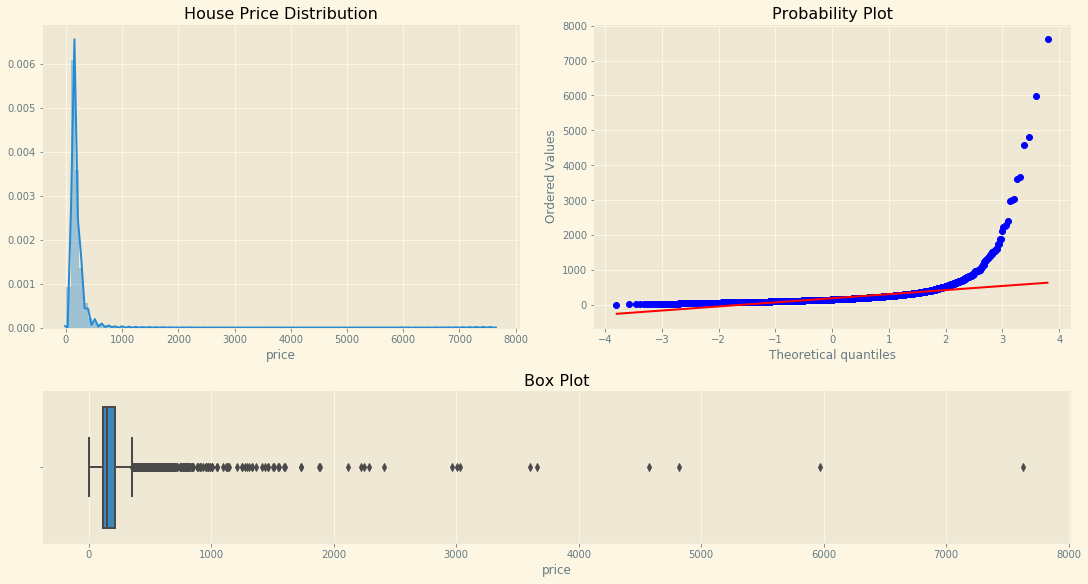

In [83]:
# build customized chart
fig = plt.figure(constrained_layout=True, figsize=(15, 8))
grid = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, height_ratios=[2, 1])

# histogram
col1 = fig.add_subplot(grid[0, :1])
col1.set_title('House Price Distribution')
sns.distplot(df['price'], bins=100)

# qqplot -> good for spotting non-normality in the tails
col2 = fig.add_subplot(grid[0, 1:])
stats.probplot(df['price'], plot=col2)

# boxplot
row2 = fig.add_subplot(grid[1, :])
row2.set_title('Box Plot')
sns.boxplot(df['price'], orient='h', ax=row2);

In [84]:
print('skew:', df['price'].skew())

skew: 15.684893467250081


The above graphs show us the following about our target variable:
* not normally distributed
* excessively skewed right
* significant outliers above the mean

In addition, the skewness of our target variable is *~15.68* which is aggregiously high (a symmetrical distribution will have a skewness of 0).

In [85]:
print(df[df['price']>400].shape, df[df['price']>1000].shape)

(434, 10) (48, 10)


Out of curiosity, it looks like there are 434 properties with sale prices greater than 400k dollars and 48 greater than 1 million dollars.

**References:**
* [Statistics 101: Is My Data Normal?](https://www.youtube.com/watch?v=9IcaQwQkE9I)
* [Normal Probability Plots Explained](https://www.youtube.com/watch?v=smJBsZ4YQZw)
* [Customizing Figure Layouts Using GridSpec and Other Functions](https://matplotlib.org/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py)

## iii) multivariate study

> Let's take a meticulous look at each variable plotted against 'price' via scatter plot. This will not only show the relationship between the two variables, but allow us to look for outliers and to confirm that the regression assumptions hold (or do not hold) for said variable. In addition, we will deploy a heat map to discover any cases of multicollinearity.

>_**Regression Assumptions:**_
* *Linearity*
* *Constant Error Variance (Homoscedasticity)*
* *Independent Error Terms*
* *Normal Errors*
* *No multicollinearity (!)*
* *Exogeneity*

In [86]:
def scatter_resid(y, x):
    fig, (col1, col2) = plt.subplots(figsize=(15,7), ncols=2)
    # scatterplot (col1)
    col1.set_title('Scatter Plot')
    sns.scatterplot(x=x, y=y, ax=col1)
    sns.regplot(x=x, y=y, ax=col1)
    # residuals (col2)
    col2.set_title('Residual Plot')
    sns.residplot(x=x, y=y, ax=col2);

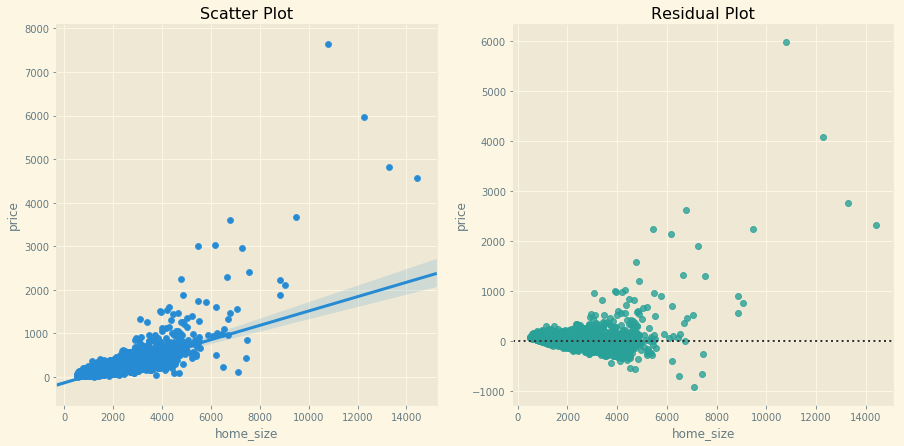

In [87]:
# home_size analysis! (HIGH IMPACT)
scatter_resid(df['price'], df['home_size'])

# home_size log-transformation
#scatter_resid(df['price'], np.log1p(df['home_size']))

#scatter_resid(np.log1p(df['price']), np.log1p(df['home_size']))

Note: The scatter plots can be somewhat misleading as, in this case, there exists 10,000+ data points before home_size reaches 6000 sqft.

**'home_size' Analysis**
* _Problems_: heteroskedasticity (meaning standard errors in output cannot be relied upon), few outliers
* _Remedies_: logarithm transformation, box-cox transformation

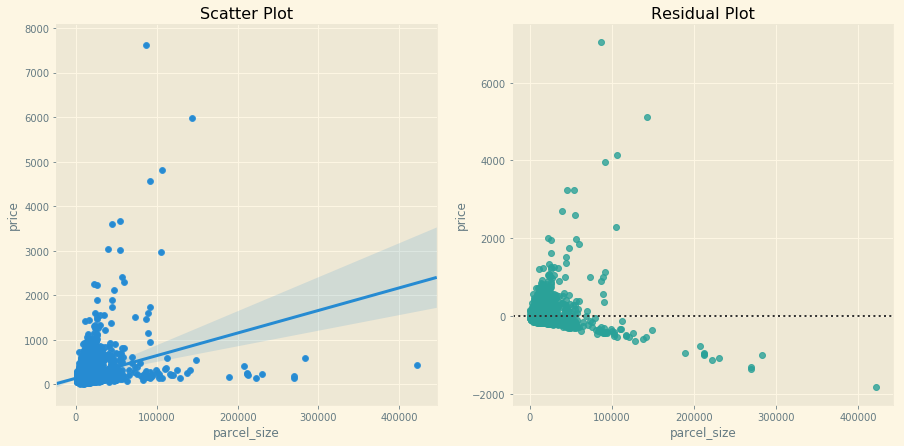

In [88]:
# parcel_size analysis! (HIGH IMPACT)
scatter_resid(df['price'], df['parcel_size'])

# parcel_size log-transformation
#scatter_resid(df['price'], np.log1p(df['parcel_size']))

**'parcel_size' Analysis**
* _Problems_: Non-linear
* _Remedies_: Get specification correct (log transform works well for this)

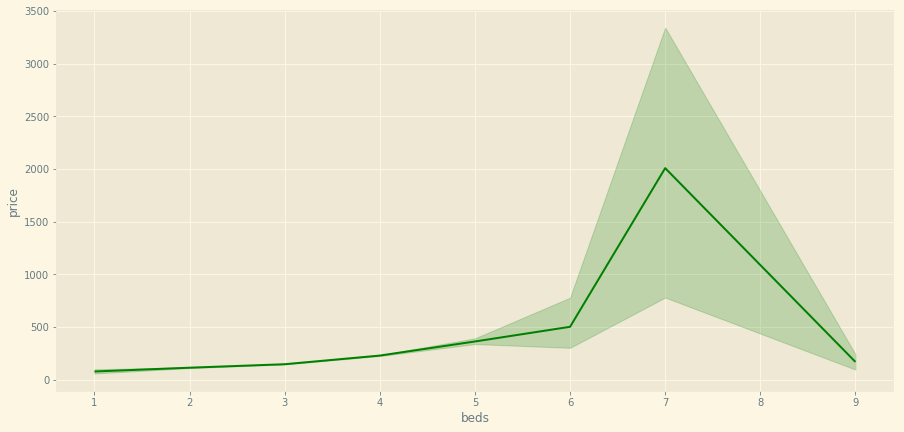

In [89]:
# beds analysis (categorical variable)! (HIGH IMPACT)
f, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(x='beds', y = 'price', color='green',data=df)

**'bed' Analysis (Categorical variable)**
* _Problems_: Outliers
* _Remedies_: Leave alone
* As price increases so does the number of beds up to 6 beds. Houses with (>6) beds are a less linear.

> Analyze heat map (correlation matrix) to identify whether there is multicollinearity o

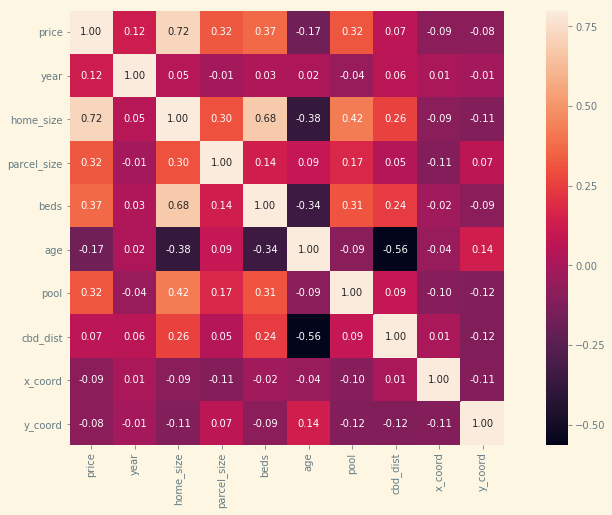

In [90]:
corr_mat = df.corr()
plt.subplots(figsize=(15,8))
sns.heatmap(corr_mat, vmax = 0.8, square = True, annot = True, fmt = '.2f')
plt.show();

**Multicollinearity Analysis**

_We can see that there is an 68% correlation between 'home_size' and 'beds'. We will consider dropping 'beds' as it correlates the least with price compared to 'home_size' for our linear regression._


In [91]:
print(corr_mat['price'].sort_values(ascending=False))

price          1.000000
home_size      0.722061
beds           0.371890
parcel_size    0.324757
pool           0.319585
year           0.123200
cbd_dist       0.065052
y_coord       -0.081188
x_coord       -0.088772
age           -0.173989
Name: price, dtype: float64


**References:**
* [Regression V: All regression assumptions explained!](https://www.youtube.com/watch?v=0MFpOQRY0rw)
* [Outliers: To Drop or Not to Drop](https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/)

## iv) conclusions

Transformations could be applied to all variables analyzed above to satisfy regression assumptions. For example, the 'home_size' variable is showing some heteroskedasticity due to the sporadic nature of houses with prices greater than 500,000 dollars. A log transformation for this specific variable handles this problem quite well.

With Dr. Scrogin's introduction to IterTools and linear regression with different variable combinations, we will avoid deleting or transforming any features from the original data set as these functions will test every possible combination.

In addition, our regularized models such as Lasso and Ridge regressions will do the clean up for us later on.

# Data Cleaning
***
> Before proceeding we will create a copy of the original data set in which we will perform all seemingly necessary transformations denoted in the Explanatory Data Analysis section of this notebook. We will then compare the modeling results with the modified data set to the modeling results of the unmodified data set using a variable combinations function similar to the one provided in class. 

In [92]:
mod_df = df.copy()
mod_df.head()

,price,year,home_size,parcel_size,beds,age,pool,cbd_dist,x_coord,y_coord
0,113.327,2004,1175,10662,3,5,0,11582.05,572058.1,1538810
1,165.509,2000,1774,5851,3,6,1,20140.86,524003.1,1465890
2,225.060,2002,1560,7750,3,32,0,1670.04,536791.3,1525977
3,105.649,2004,1296,39406,3,31,0,7529.20,510169.3,1529634
4,202.367,2005,2182,8250,4,15,1,12356.95,570802.0,1512358


In [93]:
# copy of validation data set in which we can apply changes too as well in order to keep dimensions aligned
valid = pd.read_csv('Desktop/ECO4443/data/midterm_data/validation_set.csv')
val_df = valid.copy()
val_df.head()

,price,year,home_size,parcel_size,beds,age,pool,x_coord,y_coord,cbd_dist
0,249.532,2003,2450,9489,4,0,0,482320.4,1524019,16146.14
1,164.191,2001,1621,6403,3,1,1,544833.8,1466353,19961.29
2,170.322,2003,1830,6814,3,0,0,465976.6,1505037,22433.64
3,162.771,2002,1604,11030,3,22,0,496068.3,1499013,15333.14
4,209.457,2005,2234,9083,4,2,0,604455.6,1554488,22378.00


## i) transformations

In [94]:
# now to perform log transformations on area_size and parcel_size
mod_df['home_size'] = np.log1p(mod_df['home_size'])
mod_df['parcel_size'] = np.log1p(mod_df['parcel_size'])

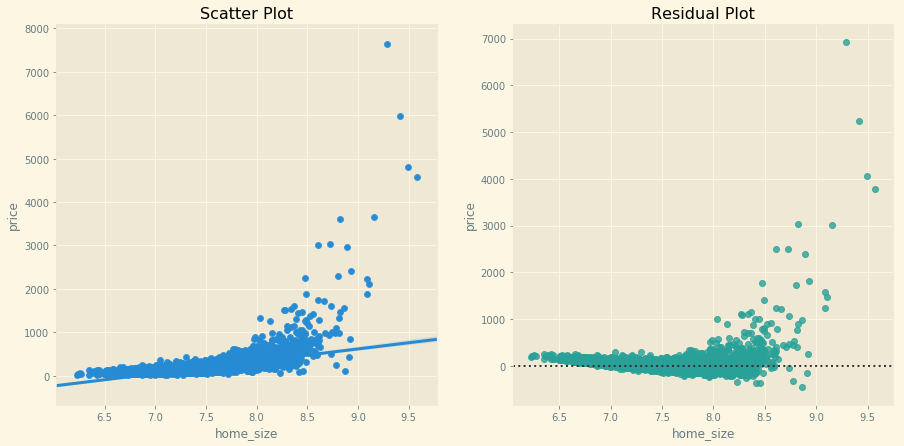

In [95]:
# home_size : log transformed
scatter_resid(mod_df['price'], mod_df['home_size'])

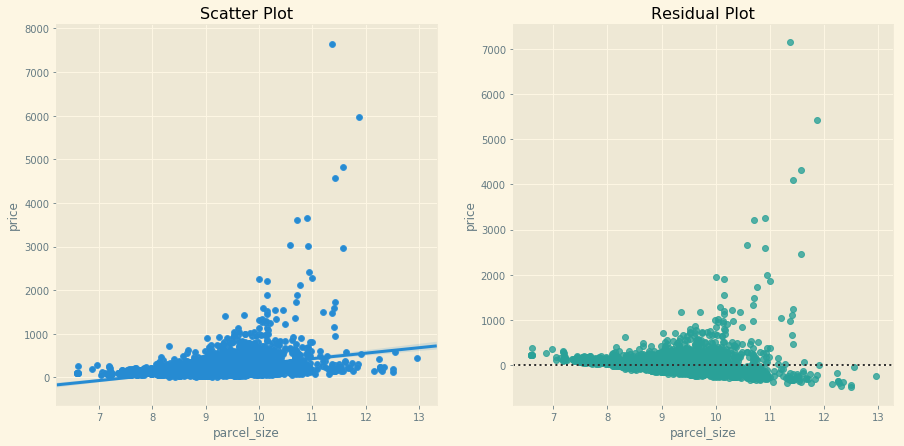

In [96]:
# parcel_size : log transformed
scatter_resid(mod_df['price'], mod_df['parcel_size'])

In [97]:
# drop beds from data set due to potential multicollinearity
mod_df.drop(['beds'], axis=1, inplace=True)
mod_df.head()

,price,year,home_size,parcel_size,age,pool,cbd_dist,x_coord,y_coord
0,113.327,2004,7.069874,9.274535,5,0,11582.05,572058.1,1538810
1,165.509,2000,7.481556,8.674539,6,1,20140.86,524003.1,1465890
2,225.060,2002,7.353082,8.955577,32,0,1670.04,536791.3,1525977
3,105.649,2004,7.167809,10.581699,31,0,7529.20,510169.3,1529634
4,202.367,2005,7.688455,9.018090,15,1,12356.95,570802.0,1512358


## ii) x/y coordinate clustering 
> experimental attempt at clustering coordinates into regions to gather more impactful information about the x/y coordinates and their relationship to the dependent variable

Text(0.5, 0, 'price')

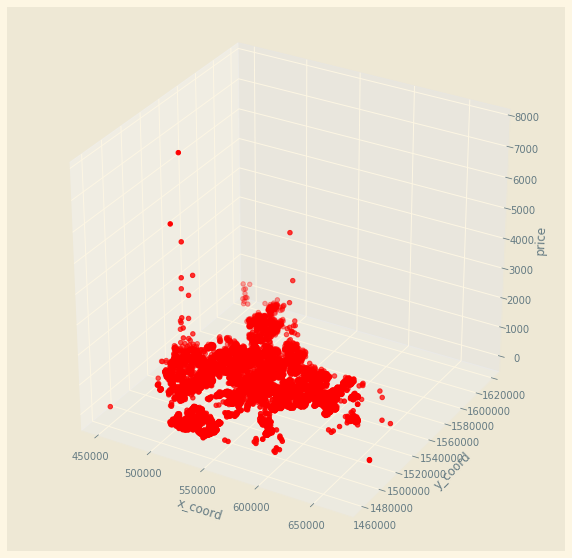

In [98]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x_coord'], df['y_coord'], df['price'], c='r', marker='o')

ax.set_xlabel('x_coord')
ax.set_ylabel('y_coord')
ax.set_zlabel('price')

_We can see that there are two regions where the majority of the extreme outliers exist_

In [99]:
coord_df = df.loc[:,['price','x_coord', 'y_coord']]
coord_df.head()

,price,x_coord,y_coord
0,113.327,572058.1,1538810
1,165.509,524003.1,1465890
2,225.060,536791.3,1525977
3,105.649,510169.3,1529634
4,202.367,570802.0,1512358


In [101]:
# cluster attempt
kmeans = KMeans(n_clusters=50, init='k-means++', random_state=1)
kmeans.fit(coord_df[coord_df.columns[1:3]])

coord_df['coord_clust'] = kmeans.fit_predict(coord_df[coord_df.columns[1:3]])
centers = kmeans.cluster_centers_

labels = kmeans.predict(coord_df[coord_df.columns[1:3]])

coord_df.head()

,price,x_coord,y_coord,coord_clust
0,113.327,572058.1,1538810,44
1,165.509,524003.1,1465890,10
2,225.060,536791.3,1525977,23
3,105.649,510169.3,1529634,13
4,202.367,570802.0,1512358,29


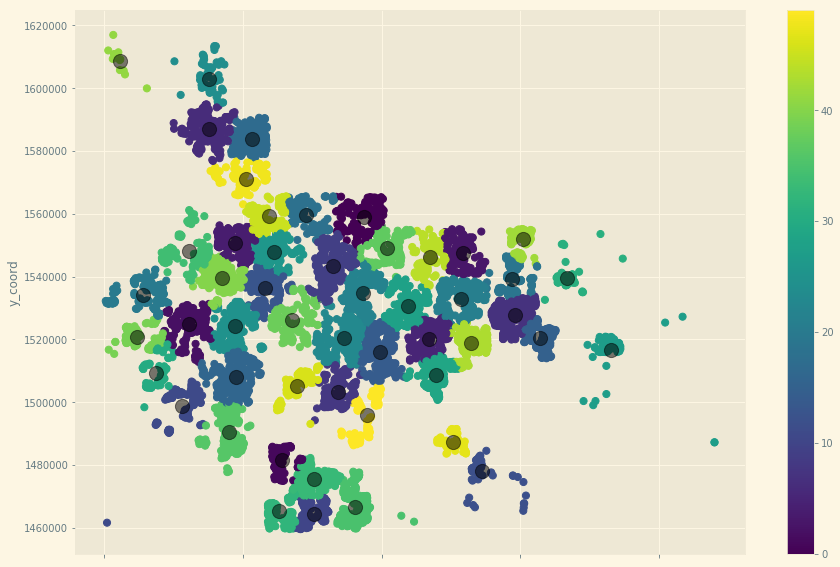

In [102]:
#visualize
coord_df.plot.scatter(x='x_coord', y='y_coord', c=labels, s=50, cmap='viridis', figsize=(15,10))
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

_The furthest cluster on the left (color: cyan) is where many very expensive houses exist. The top purple cluster is also where many expensive houses should exist. Let's take a look at these clusters plotted against price to see if these two clusters contain the outliers in question._ 

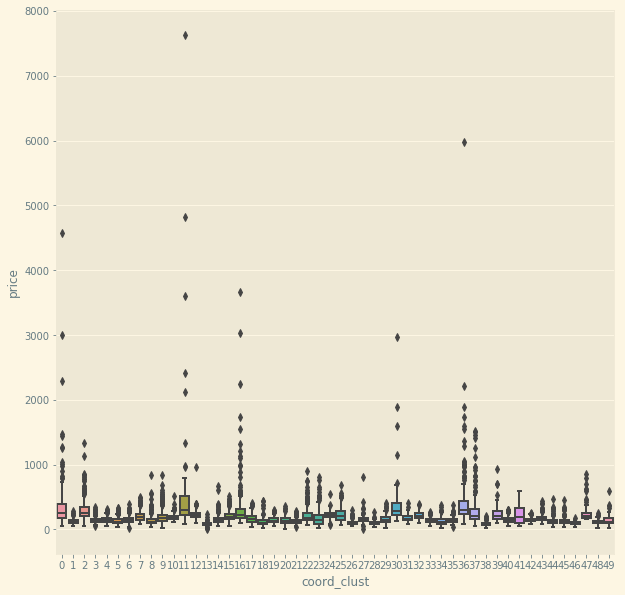

In [103]:
# lets look at relationship between 'price' and 'coord_clust'
f, ax = plt.subplots(figsize=(10,10))
fig = sns.boxplot(x='coord_clust', y='price', data=coord_df)

In [107]:
# create copy data set including new feature 'coord_clust' which we will model on
coord_df = coord_df[['price', 'coord_clust']]

# merge with original data set
clust_df = df.merge(coord_df, left_on='price', right_on='price')

# also merge to modified data set
mod_cl_df = mod_df.merge(coord_df, left_on='price', right_on='price')
mod_cl_df.head()

,price,year,home_size,parcel_size,age,pool,cbd_dist,x_coord,y_coord,coord_clust
0,113.327,2004,7.069874,9.274535,5,0,11582.05,572058.1,1538810,44
1,165.509,2000,7.481556,8.674539,6,1,20140.86,524003.1,1465890,10
2,225.060,2002,7.353082,8.955577,32,0,1670.04,536791.3,1525977,23
3,105.649,2004,7.167809,10.581699,31,0,7529.20,510169.3,1529634,13
4,105.649,2004,7.167809,10.581699,31,0,7529.20,510169.3,1529634,17


_After much trial-and-error attempting to rank each cluster, which we will call neighborhood, based on average price of houses in neighborhood I have decided to switch to an alternative method. We will proceed to one hot encode--create dummy variables--each cluster. Ideally a shrinkage regression algorithm will eliminate all cluster variables that have an average mean house price and include the few clusters that contain very expensive houses and a very high average. The goal here is to garner more accurate predictions for outlier houses and houses aboe one standard deviation from the mean._

In [108]:
encoder = OneHotEncoder(handle_unknown='ignore')

# join new one-hot encoded features to data frame
enc_df = pd.DataFrame(encoder.fit_transform(clust_df[['coord_clust']]).toarray())
clust_df = clust_df.join(enc_df)
# perform same process to mod_cl_df
mod_cl_df = mod_cl_df.join(enc_df)

In [109]:
mod_cl_df.head()

,price,year,home_size,parcel_size,age,pool,cbd_dist,x_coord,y_coord,coord_clust,...,40,41,42,43,44,45,46,47,48,49
0,113.327,2004,7.069874,9.274535,5,0,11582.05,572058.1,1538810,44,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,165.509,2000,7.481556,8.674539,6,1,20140.86,524003.1,1465890,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,225.060,2002,7.353082,8.955577,32,0,1670.04,536791.3,1525977,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,105.649,2004,7.167809,10.581699,31,0,7529.20,510169.3,1529634,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,105.649,2004,7.167809,10.581699,31,0,7529.20,510169.3,1529634,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
corr_mat = mod_cl_df.corr()
print(corr_mat['price'].sort_values(ascending=False))

price          1.000000
home_size      0.564662
parcel_size    0.325918
pool           0.302685
11             0.195874
36             0.182201
year           0.135745
0              0.124202
2              0.105411
16             0.104524
30             0.099561
cbd_dist       0.075773
37             0.068371
39             0.043826
47             0.038103
25             0.035699
15             0.034666
32             0.031315
12             0.028637
7              0.027512
22             0.025089
9              0.019023
24             0.015822
10             0.010248
41             0.006869
31             0.002105
23            -0.001905
43            -0.005850
27            -0.009151
17            -0.010570
42            -0.019658
14            -0.020119
49            -0.020476
29            -0.021754
8             -0.026626
40            -0.028193
20            -0.028757
44            -0.029113
4             -0.030098
19            -0.030892
34            -0.032586
1             -0

In [111]:
# drop x/y coord and coord_clust (redundant)
c_drop = clust_df.drop(['x_coord', 'y_coord', 'coord_clust'], axis=1)
c_drop.head()

,price,year,home_size,parcel_size,beds,age,pool,cbd_dist,0,1,...,40,41,42,43,44,45,46,47,48,49
0,113.327,2004,1175,10662,3,5,0,11582.05,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,165.509,2000,1774,5851,3,6,1,20140.86,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,225.060,2002,1560,7750,3,32,0,1670.04,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,105.649,2004,1296,39406,3,31,0,7529.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,105.649,2004,1296,39406,3,31,0,7529.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
corr = c_drop.corr()

# corr with output variable
corr_target = abs(corr['price'])

# select features
relevant_features = corr_target[corr_target>0.12]
relevant_features.index

final_df = c_drop[relevant_features.index]
final_df.head()

,price,year,home_size,parcel_size,beds,age,pool,0,11,36
0,113.327,2004,1175,10662,3,5,0,0.0,0.0,0.0
1,165.509,2000,1774,5851,3,6,1,0.0,0.0,0.0
2,225.060,2002,1560,7750,3,32,0,0.0,0.0,0.0
3,105.649,2004,1296,39406,3,31,0,0.0,0.0,0.0
4,105.649,2004,1296,39406,3,31,0,0.0,0.0,0.0


**References:**
* [Clustering GPS Coordinates and Forming Regions with Python](https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1)
* [Categorical encoding using Label-Encoding and One-Hot-Encoder](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)
* [The Ultimate Guide to 12 Dimensionality Reduction Techniques (with Python codes)](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/)

# Modeling
***

In [33]:
# function for computing MSE w/ cross validation
def mse_cv(model, x, y):
    mse = (-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10))
    return(mse)

# x & y
y = df['price']
x = df.drop('price', axis=1)

## i) linear regressions
>  $y_i = \beta_{0} + \beta_{1} x_{i1} + \cdots + \beta_{p} x_{ip} + \varepsilon_i
 = \mathbf{x}^\mathsf{T}_i\boldsymbol\beta + \varepsilon_i,
 \qquad i = 1, \ldots, n,$

In [34]:
from sklearn import metrics

# we will begin with simple linear regression using train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

regress = LinearRegression()
regress.fit(x_train, y_train)

y_pred = regress.predict(x_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 7200.731202862099


In [35]:
# now lets see the MSE with cross val
print(mse_cv(regress, x, y).mean())

15520.539719161654


In [36]:
y = mod_df['price']
x = mod_df.drop('price', axis=1)

regress = LinearRegression()

print(mse_cv(regress, x, y).mean())

22645.877182461696


In [37]:
# lets look
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.head(10)

,Actual,Predicted
2973,113.026,18.424532
823,260.676,312.334189
1045,143.809,93.420325
674,441.439,416.819505
979,144.708,437.033539
4982,277.389,311.140983
191,203.788,261.235925
3696,114.772,72.786270
6296,92.952,66.731788
2208,131.123,73.857581


In [38]:
# compute MSEs with different variable combinations using 10-fold cross validation and linear regression
def compute_combos(df, normalizeTF):
    x_combos = []
    r_sqd = {}
    mse = {}
    
    y = df['price']
    x = df.drop('price', axis=1)
    
    feat_list = x.columns
    
    for n in range(1, len(feat_list)+1):
        combos = combinations(feat_list, n)
        x_combos.extend(combos)
            
    for n in range(0, len(x_combos)):
        combo_list = list(x_combos[n])
        x = df[combo_list]
        ols = LinearRegression(normalize=normalizeTF)
        cv_scores = cross_validate(ols, x, y, cv=10, scoring=('neg_mean_squared_error', 'r2'))
        r_sqd[str(combo_list)] = np.mean(cv_scores['test_r2'])
        mse[str(combo_list)] = np.mean(cv_scores['test_neg_mean_squared_error'])

    max_r = max(r_sqd.values())
    min_mse = abs(max(mse.values()))
    print("Maximum Average Test R-Squared:", max_r.round(5))
    print("Minimum Average Test MSE:", min_mse.round(3))
    for possibles, r in r_sqd.items():
        if r == max_r:
            print("The Combination of Variables:", possibles)

In [38]:
def compute_combos_poly(df, interactionTF):
    x_combos = []
    r_sqd = {}
    mse = {}
    
    y = df['price']
    x = df.drop('price', axis=1)
    
    feat_list = x.columns
    
    for n in range(1, len(feat_list)+1):
        combos = combinations(feat_list, n)
        x_combos.extend(combos)
        
    for n in range(0, len(x_combos)):
        combo_list = list(x_combos[n])
        x = df[combo_list]
        poly = PolynomialFeatures(2, interaction_only=interactionTF)
        poly_x = poly.fit_transform(x)
        ols = LinearRegression()
        cv_scores = cross_validate(ols, poly_x, y, cv=10, scoring=('neg_mean_squared_error', 'r2'))
        r_sqd[str(combo_list)] = np.mean(cv_scores['test_r2'])
        mse[str(combo_list)] = np.mean(cv_scores['test_neg_mean_squared_error'])
    
    max_r = max(r_sqd.values())
    min_mse = abs(max(mse.values()))
    print("Maximum Average Test R-Squared:", max_r.round(5))
    print("Minimum Average Test MSE:", min_mse.round(3))
    for possibles, r in r_sqd.items():
        if r == max_r:
            print("The Combination of Variables:", possibles)

In [84]:
compute_combos(mod_df, False)

Maximum Average Test R-Squared: 0.43515
Minimum Average Test MSE: 22645.877
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'age', 'pool', 'cbd_dist', 'x_coord', 'y_coord']


In [85]:
compute_combos(mod_df, True)

Maximum Average Test R-Squared: 0.43515
Minimum Average Test MSE: 22645.877
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'age', 'pool', 'cbd_dist', 'x_coord', 'y_coord']


In [86]:
compute_combos(df, True)

Maximum Average Test R-Squared: 0.57592
Minimum Average Test MSE: 15490.141
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'beds', 'pool', 'cbd_dist', 'y_coord']


In [87]:
compute_combos(df, False)

Maximum Average Test R-Squared: 0.57592
Minimum Average Test MSE: 15490.141
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'beds', 'pool', 'cbd_dist', 'y_coord']


In [39]:
compute_combos(final_df, False)

Maximum Average Test R-Squared: 0.5542
Minimum Average Test MSE: 11539.161
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'beds', 'age', 'pool', 18, 29, 42]


In [88]:
compute_combos_poly(mod_df, True)

Maximum Average Test R-Squared: 0.59816
Minimum Average Test MSE: 14581.893
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'age', 'pool', 'cbd_dist', 'y_coord']


In [89]:
compute_combos_poly(mod_df, False)

Maximum Average Test R-Squared: 0.62482
Minimum Average Test MSE: 13451.458
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'age', 'pool', 'cbd_dist', 'x_coord', 'y_coord']


In [90]:
compute_combos_poly(df, False)

Maximum Average Test R-Squared: 0.72
Minimum Average Test MSE: 9560.377
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'age', 'pool', 'cbd_dist', 'x_coord', 'y_coord']


In [61]:
compute_combos_poly(df, True)

Maximum Average Test R-Squared: 0.65845
Minimum Average Test MSE: 10892.037
The Combination of Variables: ['year', 'home_size', 'beds', 'age', 'pool', 'cbd_dist', 'x_coord', 'y_coord']


In [56]:
# test on final_df
compute_combos(final_df, True)

Maximum Average Test R-Squared: 0.55343
Minimum Average Test MSE: 11554.432
The Combination of Variables: ['year', 'home_size', 'parcel_size', 'beds', 'age', 'pool', 0, 35, 36]


In [60]:
compute_combos_poly(final_df, False)

Maximum Average Test R-Squared: 0.70339
Minimum Average Test MSE: 7289.295
The Combination of Variables: ['year', 'home_size', 'beds', 'pool']


## ii) lasso/ridge

In [39]:
# lasso function with 10-fold cross validation and alpha tuning using GridSearch
import warnings
warnings.filterwarnings("ignore")

def find_alpha(x, y, model):
    alphas = [1, 0.1, 0.01, 0.001, 0.0001]
    grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), 
                        scoring=('neg_mean_squared_error', 'r2'), cv=10, refit=('r2'))
    grid.fit(x, y)
    return grid.best_estimator_.alpha

def compute_lasso(df, poly = False, norm = False):
    y = df['price']
    x = df.drop('price', axis=1)
    
    model = Lasso()
    
    if poly==True:
        poly = PolynomialFeatures(2, interaction_only=False)
        x = poly.fit_transform(x)
    
    scores = cross_validate(Lasso(alpha=find_alpha(x, y, model), max_iter=15000, normalize=norm), x, y, cv=10, 
                            scoring=('neg_mean_squared_error', 'r2'))
    
    print("Maximum Average R-Squared:", np.mean(scores['test_r2']).round(5))
    print("Minimum Average MSE:", -np.mean(scores['test_neg_mean_squared_error']).round(3))

In [102]:
compute_lasso(df, False, True)

Maximum Average R-Squared: 0.57161
Minimum Average MSE: 16351.18


In [103]:
compute_lasso(df, False, False)

Maximum Average R-Squared: 0.57545
Minimum Average MSE: 15520.547


In [104]:
compute_lasso(mod_df, True, True)

Maximum Average R-Squared: 0.56423
Minimum Average MSE: 18237.08


In [186]:
compute_lasso(clust_df, False, False)

Maximum Average Test R-Squared: 0.58218
Minimum Average Test MSE: 10943.186


In [169]:
compute_lasso(clust_df)

Maximum Average Test R-Squared: 0.58218
Minimum Average Test MSE: 10943.186


In [42]:
compute_lasso(final_df)

Maximum Average R-Squared: 0.55504
Minimum Average MSE: 11527.225


In [40]:
compute_lasso(final_df, True, False)

Maximum Average R-Squared: 0.63055
Minimum Average MSE: 8751.593


In [68]:
# with interaction effects turned on
compute_lasso(final_df, True, False)

Maximum Average R-Squared: 0.53267
Minimum Average MSE: 10554.753


---

In [31]:
# Ridge function with 10-fold cross validation and alpha tuning using GridSearch
import warnings
warnings.filterwarnings("ignore")

def compute_ridge(df, poly=False, norm=False):
    y = df['price']
    x = df.drop('price', axis=1)
    
    model = Ridge()
    
    if poly==True:
        poly = PolynomialFeatures(2, interaction_only=False)
        x = poly.fit_transform(x)
    
    scores = cross_validate(Ridge(alpha=find_alpha(x, y, model), max_iter=15000, normalize=norm), x, y, cv=10, 
                            scoring=('neg_mean_squared_error', 'r2'))
    
    print("Maximum Average R-Squared:", np.mean(scores['test_r2']).round(5))
    print("Minimum Average MSE:", -np.mean(scores['test_neg_mean_squared_error']).round(3))

In [128]:
compute_ridge(df, True, False)

Maximum Average R-Squared: 0.71013
Minimum Average MSE: 10629.824


In [127]:
compute_ridge(mod_df, False, False)

Maximum Average R-Squared: 0.43523
Minimum Average MSE: 22645.823


In [39]:
compute_ridge(clust_df, False, False)

Maximum Average R-Squared: 0.58627
Minimum Average MSE: 10871.703


In [40]:
compute_ridge(final_df, True, False)

Maximum Average R-Squared: 0.64664
Minimum Average MSE: 8095.829


## iii) bagging/boosting

>random forest adaptation with  10-fold CV

In [76]:
import warnings
warnings.filterwarnings("ignore")

# exhaustive hyperparameter grid (this is process is too 'exhaustive' for my computer and has been aborted)
#def find_params():
#    n_estimators = [100, 1200]
#    max_depth = [5, 30]
#    min_samples_split = [2, 100] 
#    min_samples_leaf = [1, 10]
    
#    tune = dict(n_estimators = n_estimators, max_depth = max_depth, 
#                min_samples_split = min_samples_split, 
#                min_samples_leaf = min_samples_leaf)
    
#    run_forest = RandomForestRegressor()
    
#    grid = GridSearchCV(run_forest, tune, cv=10)

def compute_rf(df, poly=False):
    y = df['price']
    x = df.drop('price', axis=1)
    
    # lets try that polynomial conversion
    if poly==True:
        pol = PolynomialFeatures(2, interaction_only=False)
        x = pol.fit_transform(x)

    forest = RandomForestRegressor()    
    
    scores = cross_validate(forest, x, y, cv=10, 
                            scoring=('neg_mean_squared_error', 'r2'))
    
    print("Maximum Average R-Squared:", np.mean(scores['test_r2']).round(5))
    print("Minimum Average MSE:", -np.mean(scores['test_neg_mean_squared_error']).round(3))

In [78]:
compute_rf(df, True)

Maximum Average R-Squared: 0.76193
Minimum Average MSE: 7349.938


In [79]:
compute_rf(df)

Maximum Average R-Squared: 0.79649
Minimum Average MSE: 6575.054


In [80]:
compute_rf(mod_df)

Maximum Average R-Squared: 0.75636
Minimum Average MSE: 7978.078


In [47]:
compute_rf(final_df, True)

Maximum Average R-Squared: 0.71121
Minimum Average MSE: 6798.135


In [52]:
compute_rf(final_df)

Maximum Average R-Squared: 0.70396
Minimum Average MSE: 6937.405


In [48]:
# out of curiosity -> final_df with logged features from mod_df
final_df['home_size'] = np.log1p(final_df['home_size'])
final_df['parcel_size'] = np.log1p(final_df['parcel_size'])
compute_rf(final_df)

Maximum Average R-Squared: 0.72311
Minimum Average MSE: 6211.805


**References:**
* [A Comprehensive Guide To Ensemble Learning (with Python codes)](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/)
* [Tuning the parameters of your Random Forest model](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/)

## iv) model validation

In [75]:
valid = pd.read_csv('Desktop/ECO4443/data/midterm_data/validation_set.csv')
valid.head()

,price,year,home_size,parcel_size,beds,age,pool,x_coord,y_coord,cbd_dist
0,249.532,2003,2450,9489,4,0,0,482320.4,1524019,16146.14
1,164.191,2001,1621,6403,3,1,1,544833.8,1466353,19961.29
2,170.322,2003,1830,6814,3,0,0,465976.6,1505037,22433.64
3,162.771,2002,1604,11030,3,22,0,496068.3,1499013,15333.14
4,209.457,2005,2234,9083,4,2,0,604455.6,1554488,22378.00


> Apply preprocessing that elicited that best results from the cross validation above.
* kmeans clustering on x/y_coord
* one-hot-encode new coord_clust feature
* remove x/y_coord, coord_clust, all features below 0.12 correlation
* log transform home_size and parcel_size

In [55]:
# attempt to perform same transformation with kmeans clustering on validation set proved very difficult due to the nature of the validation set.
# validation neighborhoods were vastly different than neighborhood in training set.
# this was a major overstep of which I spent many days trying to fix.
# in the future I will use a pipeline and perhaps a clustering algorithm more appropriate for this job.

In [113]:
forest = RandomForestRegressor()

y = df['price']
x = df.drop('price', axis=1)

val_y = valid['price']
val_x = valid.drop('price', axis=1)

forest.fit(x, y)
y_pred = forest.predict(val_x)

C:\Users\Chimerical\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [114]:
from sklearn.metrics import mean_squared_error
mean_squared_error(val_y, y_pred)

8249.84488852483